In [1]:
!pip install -q kaggle

In [4]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.1 MB/s eta 0:00:00


Загружаем данные

In [2]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c compl-sber-ds-test

  0% 0.00/6.21M [00:00<?, ?B/s]
100% 6.21M/6.21M [00:00<00:00, 66.7MB/s]


In [5]:
!unzip compl-sber-ds-test.zip

Archive:  compl-sber-ds-test.zip
  inflating: client_measures.csv     
  inflating: test.csv                
  inflating: train.csv               
  inflating: transactions.csv        


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, classification_report, precision_recall_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
import warnings
import catboost as cb

warnings.filterwarnings("ignore")

In [31]:
df_trans = pd.read_csv("transactions.csv")
df_client = pd.read_csv("client_measures.csv")
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

## EDA

In [8]:
print('Transactions')
print(df_trans.columns)
print(df_trans.dtypes)

print('\n\nClient')
print(df_client.columns)
print(df_client.dtypes)

print('\n\nTrain')
print(df_train.columns)
print(df_train.dtypes)

print('\n\nTest')
print(df_test.columns)
print(df_test.dtypes)

Transactions
Index(['client_id', 'trxn_direction', 'trxn_date', 'trxn_ammount', 'fl_0',
       'fl_1', 'fl_2', 'fl_3', 'fl_4', 'fl_5', 'fl_6', 'fl_7', 'fl_8', 'fl_9',
       'fl_10', 'fl_11', 'fl_12', 'fl_13', 'fl_14', 'fl_15', 'fl_16', 'fl_17',
       'fl_18', 'fl_19', 'fl_20', 'fl_21', 'fl_22', 'fl_23', 'fl_24', 'fl_25',
       'fl_26', 'fl_27', 'fl_28', 'fl_29', 'fl_30', 'fl_31', 'fl_32', 'fl_33',
       'fl_34', 'fl_35', 'fl_36', 'fl_37', 'fl_38', 'fl_39'],
      dtype='object')
client_id           int64
trxn_direction      int64
trxn_date          object
trxn_ammount      float64
fl_0                int64
fl_1                int64
fl_2                int64
fl_3                int64
fl_4                int64
fl_5                int64
fl_6                int64
fl_7                int64
fl_8                int64
fl_9                int64
fl_10               int64
fl_11               int64
fl_12               int64
fl_13               int64
fl_14               int64
fl_15             

Очевидна проблема сильного дисбаланса классов

Text(0.5, 1.0, 'Target (0: Not blocked or 1: Blocked)')

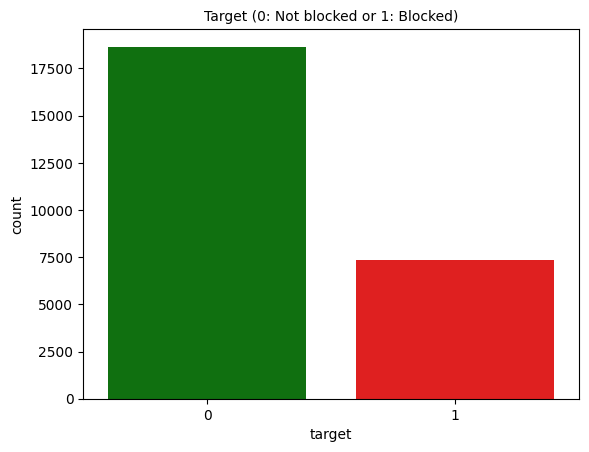

In [ ]:
colors = ["green", "red"]

sns.countplot(x='target', data=df_train, palette=colors)
plt.title('Target (0: Not blocked or 1: Blocked)', fontsize=10)

Посмотрим какие уникальные категориальные значения в столбце __index_3__

In [10]:
df_client['index_3'].value_counts()

index_3
l3    5518
l2    3287
l1     944
Name: count, dtype: int64

Заполним пропуски модой по столбцу

In [32]:
for col in df_test.columns:
  df_test[col] = df_test[col].fillna(df_test[col].mode())
for col in df_train.columns:
  df_train[col] = df_train[col].fillna(df_train[col].mode())

Объединим таблицы по __client_id__, уберём категориальные признаки (даты) и сделаем из категориального признака __index_3__ числовой

In [33]:
df_train.drop('trigger_dt', axis=1, inplace=True)
df_test.drop('trigger_dt', axis=1, inplace=True)
df_trans.drop('trxn_date', axis=1, inplace=True)

df_trans = df_trans.groupby(['client_id']).mean() #для каждого клиента возьмём среднее по транзакциям

#мёрджим таблицу train и transactions по client_id
df_train = pd.merge(df_train, df_trans, on='client_id', how='left')
df_test = pd.merge(df_test, df_trans, on='client_id', how='left')

#мёрджим таблицу train и client_measures по client_id
df_train = pd.merge(df_train, df_client, on='client_id', how='left')
df_test = pd.merge(df_test, df_client, on='client_id', how='left')

#удалим порядковые признаки
df_test.drop('client_id', axis=1, inplace=True)
df_train.drop('client_id', axis=1, inplace=True)

#заменим категориальные признаки на числовые
df_test['index_3'] = df_test['index_3'].replace({'l1': 1, 'l2': 2, 'l3': 3})
df_train['index_3'] = df_train['index_3'].replace({'l1': 1, 'l2': 2, 'l3': 3})

Посмотрим на матрицу корреляций (но она покажет только линейные зависимости)

<Axes: >

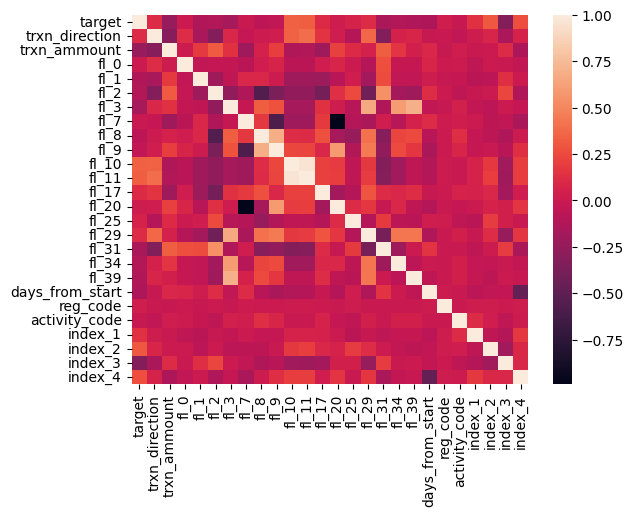

In [ ]:
corr = df_train.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [ ]:
X = df_train.drop('target', axis=1)
y = df_train['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model_cat = cb.CatBoostClassifier(iterations=1000,
                              loss_function='Logloss',
                              eval_metric='Accuracy',
                              learning_rate=0.01,
                              random_seed=42,
                              auto_class_weights='SqrtBalanced',
                              task_type='GPU')


model_cat.fit(X_train, y_train)

0:	learn: 0.7768209	total: 204ms	remaining: 3m 24s
1:	learn: 0.7876944	total: 376ms	remaining: 3m 7s
2:	learn: 0.7886641	total: 554ms	remaining: 3m 4s
3:	learn: 0.7916157	total: 726ms	remaining: 3m
4:	learn: 0.7952927	total: 881ms	remaining: 2m 55s
5:	learn: 0.7924852	total: 1.13s	remaining: 3m 6s
6:	learn: 0.7938449	total: 1.31s	remaining: 3m 6s
7:	learn: 0.7936981	total: 1.5s	remaining: 3m 5s
8:	learn: 0.7954261	total: 1.67s	remaining: 3m 3s
9:	learn: 0.7985774	total: 1.84s	remaining: 3m 2s
10:	learn: 0.7993056	total: 2.05s	remaining: 3m 4s
11:	learn: 0.8008065	total: 2.25s	remaining: 3m 4s
12:	learn: 0.8004244	total: 2.41s	remaining: 3m 3s
13:	learn: 0.8005185	total: 2.58s	remaining: 3m 1s
14:	learn: 0.8016428	total: 2.74s	remaining: 3m
15:	learn: 0.8017618	total: 2.92s	remaining: 2m 59s
16:	learn: 0.8010834	total: 3.08s	remaining: 2m 57s
17:	learn: 0.8014296	total: 3.32s	remaining: 3m 1s
18:	learn: 0.8041959	total: 3.5s	remaining: 3m
19:	learn: 0.8029553	total: 3.73s	remaining: 3m 

Посмотрим на feauture importance и уберём "слабые" признаки

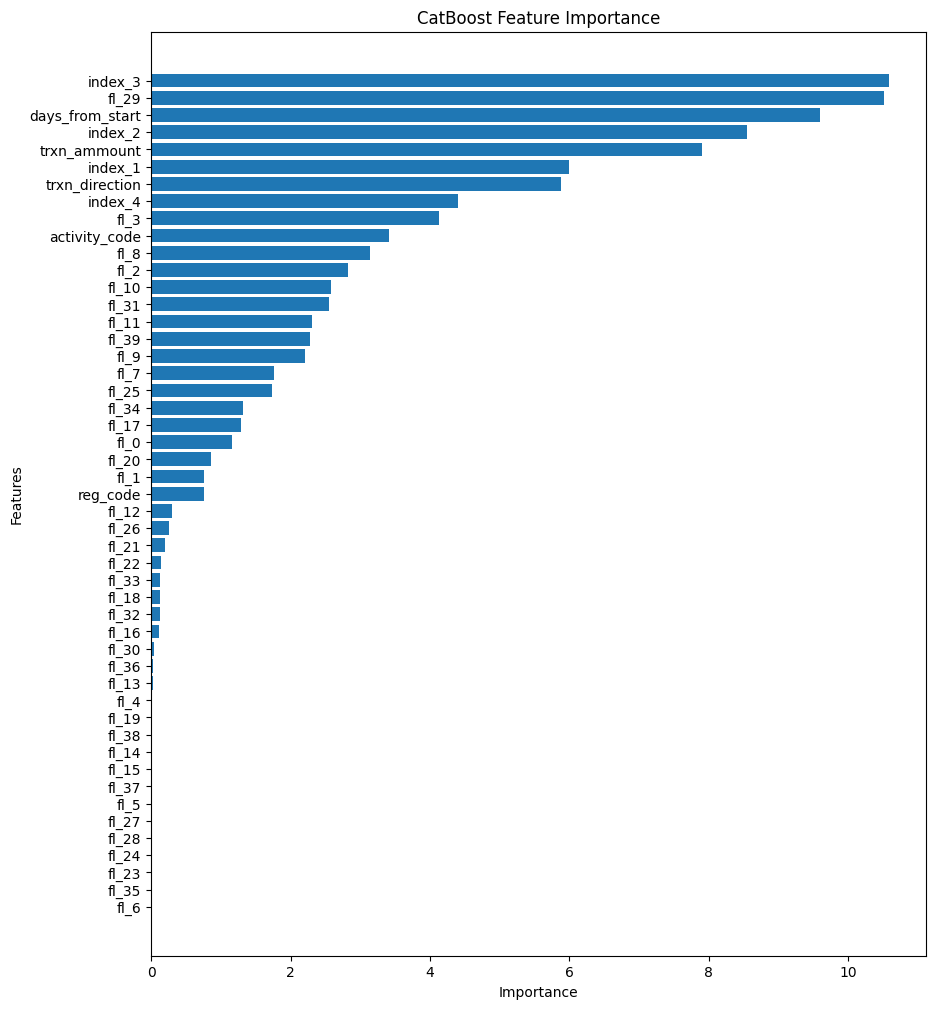

In [ ]:
importances = model_cat.get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.Series(importances, index=X.columns).sort_values()
plt.figure(figsize=(10, 12))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [ ]:
df_train = df_train.drop(feature_importances.index[feature_importances.values < 0.4], axis=1)
df_test = df_test.drop(feature_importances.index[feature_importances.values < 0.4], axis=1)
df_train.columns

Index(['target', 'trxn_direction', 'trxn_ammount', 'fl_0', 'fl_1', 'fl_2',
       'fl_3', 'fl_7', 'fl_8', 'fl_9', 'fl_10', 'fl_11', 'fl_17', 'fl_20',
       'fl_25', 'fl_29', 'fl_31', 'fl_34', 'fl_39', 'days_from_start',
       'reg_code', 'activity_code', 'index_1', 'index_2', 'index_3',
       'index_4'],
      dtype='object')

In [13]:
X = df_train.drop('target', axis=1)
y = df_train['target']

Запустим пайплайн для подбора гиперпараметров

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
params = {
    'auto_class_weights': ['Balanced', 'SqrtBalanced'],
    'iterations': [800, 1000, 1500],
    'learning_rate': [0.01, 0.005],
    'depth': [6, 8]
}
#'auto_class_weights': ['Balanced', 'SqrtBalanced'] - балансируем классы

skf = StratifiedKFold(n_splits=3, random_state=None, shuffle=False)

catboost_classifier = cb.CatBoostClassifier(loss_function='Logloss',
                              eval_metric='Accuracy',
                              random_seed=42,
                              task_type='GPU')

model_CatB = make_pipeline(GridSearchCV(catboost_classifier,
                        param_grid=params,
                        scoring='roc_auc',
                        cv=skf,
                        verbose=1,
                        return_train_score=True))


model_CatB.fit(X_train, y_train)

Выходные данные были обрезаны до нескольких последних строк (5000).
1000:	learn: 0.8567363	total: 1m 21s	remaining: 40.7s
1001:	learn: 0.8567363	total: 1m 21s	remaining: 40.6s
1002:	learn: 0.8567363	total: 1m 21s	remaining: 40.6s
1003:	learn: 0.8566948	total: 1m 21s	remaining: 40.5s
1004:	learn: 0.8566948	total: 1m 22s	remaining: 40.4s
1005:	learn: 0.8569482	total: 1m 22s	remaining: 40.3s
1006:	learn: 0.8568069	total: 1m 22s	remaining: 40.2s
1007:	learn: 0.8568069	total: 1m 22s	remaining: 40.1s
1008:	learn: 0.8570313	total: 1m 22s	remaining: 40.1s
1009:	learn: 0.8570728	total: 1m 22s	remaining: 40s
1010:	learn: 0.8572140	total: 1m 22s	remaining: 39.9s
1011:	learn: 0.8572846	total: 1m 22s	remaining: 39.8s
1012:	learn: 0.8573552	total: 1m 22s	remaining: 39.7s
1013:	learn: 0.8569897	total: 1m 22s	remaining: 39.6s
1014:	learn: 0.8569191	total: 1m 22s	remaining: 39.6s
1015:	learn: 0.8569897	total: 1m 22s	remaining: 39.5s
1016:	learn: 0.8570313	total: 1m 22s	remaining: 39.4s
1017:	learn: 0.8

Pipeline(steps=[('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                              estimator=<catboost.core.CatBoostClassifier object at 0x7c9b6ab03940>,
                              param_grid={'auto_class_weights': ['Balanced',
                                                                 'SqrtBalanced'],
                                          'depth': [6, 8],
                                          'iterations': [800, 1000, 1500],
                                          'learning_rate': [0.01, 0.005]},
                              return_train_score=True, scoring='roc_auc',
                              verbose=1))])

Лучшая модель со следующими гиперпараметрами

In [ ]:
best_params = model_CatB.named_steps['gridsearchcv'].best_params_
best_params

{'auto_class_weights': 'SqrtBalanced',
 'depth': 8,
 'iterations': 1500,
 'learning_rate': 0.01}

In [ ]:
print("Accuracy:", accuracy_score(model_CatB.predict(X_test), y_test))
print("Presicion:", precision_score(model_CatB.predict(X_test), y_test))
print("Recall:", recall_score(model_CatB.predict(X_test), y_test))
print("ROC_AUC:", roc_auc_score(model_CatB.predict(X_test), y_test))
print('\n\n\n')
print(classification_report(model_CatB.predict(X_test), y_test))

Обучим три модели бустинга

In [14]:
catboost_classifier_arr = []
rand_idxs = [42, 123, 4567]
for i in rand_idxs:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
  catboost_classifier_arr.append(cb.CatBoostClassifier(iterations=1500,
                              loss_function='Logloss',
                              eval_metric='Accuracy',
                              learning_rate=0.01,
                              random_seed=i,
                              task_type='GPU',
                              depth=8,
                              auto_class_weights='SqrtBalanced'))
  catboost_classifier_arr[-1].fit(X_train, y_train)

0:	learn: 0.7992398	total: 206ms	remaining: 5m 8s
1:	learn: 0.8116337	total: 324ms	remaining: 4m 2s
2:	learn: 0.8078512	total: 418ms	remaining: 3m 28s
3:	learn: 0.8086488	total: 506ms	remaining: 3m 9s
4:	learn: 0.8102465	total: 594ms	remaining: 2m 57s
5:	learn: 0.8125947	total: 688ms	remaining: 2m 51s
6:	learn: 0.8157652	total: 775ms	remaining: 2m 45s
7:	learn: 0.8163163	total: 863ms	remaining: 2m 40s
8:	learn: 0.8132040	total: 953ms	remaining: 2m 37s
9:	learn: 0.8130267	total: 1.04s	remaining: 2m 35s
10:	learn: 0.8154661	total: 1.13s	remaining: 2m 32s
11:	learn: 0.8163661	total: 1.23s	remaining: 2m 32s
12:	learn: 0.8164463	total: 1.32s	remaining: 2m 30s
13:	learn: 0.8167703	total: 1.41s	remaining: 2m 29s
14:	learn: 0.8168174	total: 1.5s	remaining: 2m 28s
15:	learn: 0.8162663	total: 1.58s	remaining: 2m 27s
16:	learn: 0.8162193	total: 1.67s	remaining: 2m 25s
17:	learn: 0.8168368	total: 1.76s	remaining: 2m 25s
18:	learn: 0.8170251	total: 1.86s	remaining: 2m 24s
19:	learn: 0.8174626	total

Метрики трёх моделей бустинга

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345678)

In [15]:
arr_pred = []
arr_pred_proba = []
for i in range(3):
  print(f'Random: {rand_idxs[i]}')
  arr_pred.append(catboost_classifier_arr[i].predict(X_test))
  arr_pred_proba.append(catboost_classifier_arr[i].predict_proba(X_test)[:,1])
  print("Accuracy:", accuracy_score(arr_pred[-1], y_test))
  print("Presicion:", precision_score(arr_pred[-1], y_test))
  print("Recall:", recall_score(arr_pred[-1], y_test))
  print("ROC_AUC:", roc_auc_score(arr_pred[-1], y_test))
  print('\n')
  print(classification_report(arr_pred[-1], y_test), '\n\n\n')

Random: 42
Accuracy: 0.8833632401948218
Presicion: 0.7568306010928961
Recall: 0.8155053974484789
ROC_AUC: 0.8614307001121645


              precision    recall  f1-score   support

           0       0.93      0.91      0.92      5764
           1       0.76      0.82      0.79      2038

    accuracy                           0.88      7802
   macro avg       0.84      0.86      0.85      7802
weighted avg       0.89      0.88      0.88      7802
 



Random: 123
Accuracy: 0.8822096898231223
Presicion: 0.7481785063752276
Recall: 0.8178198108511697
ROC_AUC: 0.8611798864371506


              precision    recall  f1-score   support

           0       0.93      0.90      0.92      5793
           1       0.75      0.82      0.78      2009

    accuracy                           0.88      7802
   macro avg       0.84      0.86      0.85      7802
weighted avg       0.89      0.88      0.88      7802
 



Random: 4567
Accuracy: 0.8841322737759549
Presicion: 0.7545537340619308
Recall: 0.8

Возьмем голосование по большинству трёх моделей

In [16]:
pred = np.median(arr_pred, axis=0)
pred_proba = np.mean(arr_pred_proba, axis=0)
print("Accuracy:", accuracy_score(pred, y_test))
print("Presicion:", precision_score(pred, y_test))
print("Recall:", recall_score(pred, y_test))
print("ROC_AUC:", roc_auc_score(pred, y_test))
print('\n')
print(classification_report(pred, y_test), '\n\n\n')

Accuracy: 0.8842604460394771
Presicion: 0.7527322404371585
Recall: 0.8211624441132638
ROC_AUC: 0.8636819302963968


              precision    recall  f1-score   support

         0.0       0.94      0.91      0.92      5789
         1.0       0.75      0.82      0.79      2013

    accuracy                           0.88      7802
   macro avg       0.84      0.86      0.85      7802
weighted avg       0.89      0.88      0.89      7802
 





Построим ROC кривую

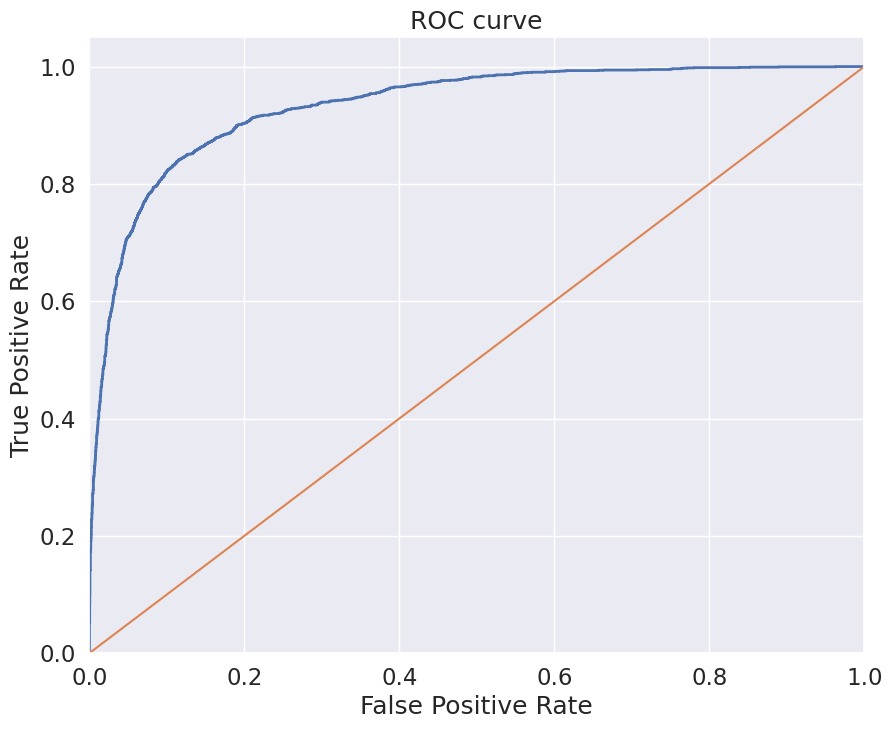

In [17]:
sns.set(font_scale=1.5)

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_test, pred_proba, pos_label=1)
plt.plot(fpr, tpr, lw=2, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

Построим PR кривую

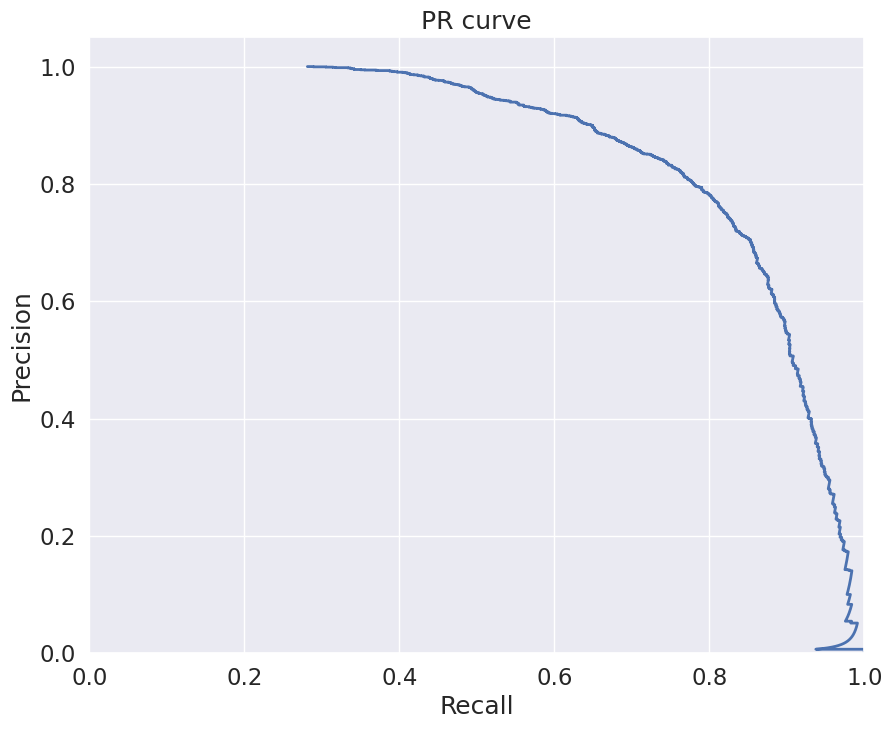

In [26]:
sns.set(font_scale=1.5)

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = precision_recall_curve(y_test, pred_proba, pos_label=1)
plt.plot(fpr, tpr, lw=2, label='PR curve ')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve')
plt.show()

## Обучение моделей

Теперь обучим на всём датасете три модели

In [34]:
X_train = df_train.drop('target', axis=1)
y_train = df_train['target']
X_test = df_test

catboost_classifier_predictions_arr = [] #предсказанный класс
catboost_classifier_predictions_proba_arr = [] #вероятность принадлежности к классу 1
rand_idxs = [42, 123, 4567]
for i in rand_idxs:
  catboost_classifier = cb.CatBoostClassifier(iterations=1500,
                              loss_function='Logloss',
                              eval_metric='Accuracy',
                              learning_rate=0.01,
                              random_seed=i,
                              task_type='GPU',
                              depth=8,
                              auto_class_weights='SqrtBalanced')
  catboost_classifier.fit(X_train, y_train)
  catboost_classifier.save_model(f"model_rand_{i}")
  catboost_classifier_predictions_arr.append(catboost_classifier.predict(X_test))
  catboost_classifier_predictions_proba_arr.append(catboost_classifier.predict_proba(X_test)[:, 1])

0:	learn: 0.7993663	total: 185ms	remaining: 4m 36s
1:	learn: 0.8079762	total: 334ms	remaining: 4m 10s
2:	learn: 0.8108845	total: 431ms	remaining: 3m 35s
3:	learn: 0.8090678	total: 525ms	remaining: 3m 16s
4:	learn: 0.8115442	total: 626ms	remaining: 3m 7s
5:	learn: 0.8112981	total: 722ms	remaining: 2m 59s
6:	learn: 0.8106928	total: 814ms	remaining: 2m 53s
7:	learn: 0.8127068	total: 903ms	remaining: 2m 48s
8:	learn: 0.8128717	total: 994ms	remaining: 2m 44s
9:	learn: 0.8131840	total: 1.08s	remaining: 2m 41s
10:	learn: 0.8129081	total: 1.17s	remaining: 2m 38s
11:	learn: 0.8129542	total: 1.26s	remaining: 2m 36s
12:	learn: 0.8137802	total: 1.39s	remaining: 2m 38s
13:	learn: 0.8138985	total: 1.52s	remaining: 2m 41s
14:	learn: 0.8133713	total: 1.67s	remaining: 2m 45s
15:	learn: 0.8136788	total: 1.78s	remaining: 2m 45s
16:	learn: 0.8136642	total: 1.88s	remaining: 2m 44s
17:	learn: 0.8137741	total: 1.94s	remaining: 2m 39s
18:	learn: 0.8136997	total: 2.04s	remaining: 2m 39s
19:	learn: 0.8145414	to

In [35]:
y_pred = np.median(catboost_classifier_predictions_arr, axis=0)
y_pred_proba = np.round(np.mean(catboost_classifier_predictions_proba_arr, axis=0), 2)

#Создаём новую таблицу
df_res = pd.read_csv("test.csv")
df_res['Id'] = df_res['client_id'].astype(str) + '_' + df_res['trigger_dt'].astype(str)
df_res.drop(['client_id', 'trigger_dt'], axis=1, inplace=True)
df_res['Predicted'] = y_pred_proba
df_res.to_csv("result.csv")